# Assignment 1

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from scipy.optimize import minimize
from scipy import optimize

figpath = r"/Users/bruger/Desktop/Exam/Project 1/Figures"

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# load local model file and initialize model class
from Pyfile import DynLaborFertModelClass
model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3,'stoch_s':0}) # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim

In [3]:
# Give names to simulations
cons = 'c'
hours = 'h'
kids = 'n'
assets = 'a'
capital = 'k'
spouse = 's'

# Question 1
In the following, I solve and simulate the model for a different number of $\beta_{1}$-values. 

a) I calculate mean optimal hours in time relevant to brith and save these for each of the $\beta_{1}$-values. 

b) I plot mean hours worked and pct. changed in mean hours worked relative to period $t-1$.

c) I perform structural estimation to find the $\beta_{1}$-value that minimizes the distance between model and data moments. 

In [37]:
# a) Solve and simulate model for multiple values of beta (eye ball econometrics)
beta_1_list = [0.02, 0.03, 0.04, 0.05, 0.06]
m_hours_b = {}

for beta_1 in beta_1_list:
    model.par.beta_1 = beta_1
    model.solve()
    model.simulate()

    birth = np.zeros(sim.n.shape,dtype=np.int_)
    birth[:,1:] = (sim.n[:,1:] - sim.n[:,:-1]) > 0 #G enerates an 1D-array array where 1-values indicate that a birth occurred between two periods 
    
    periods = np.tile([t for t in range(par.simT)],(par.simN,1))
    time_of_birth = np.max(periods * birth, axis=1)
    
    I = time_of_birth>0
    time_of_birth[~I] = -1000 # never has a child
    time_of_birth = np.transpose(np.tile(time_of_birth , (par.simT,1)))
    
    time_since_birth = periods - time_of_birth

    min_time = -8
    max_time = 8
    event_grid = np.arange(min_time,max_time+1)

    event_hours = np.nan + np.zeros(event_grid.size)
    for t,time in enumerate(event_grid):
        event_hours[t] = np.mean(sim.h[time_since_birth==time])

    # relative to period before birth
    event_hours_rel = event_hours - event_hours[event_grid==-1]

    event_hours_rel_pct = (event_hours - event_hours[event_grid==-1])/ event_hours[event_grid==-1] 

    m_hours_b[beta_1] = event_hours
    m_hours_b[(beta_1, 'rel')] = event_hours_rel_pct

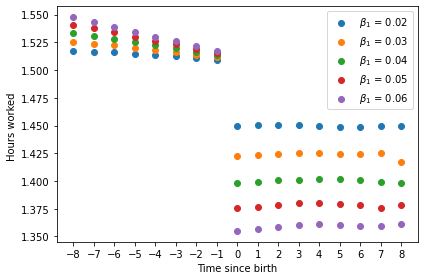

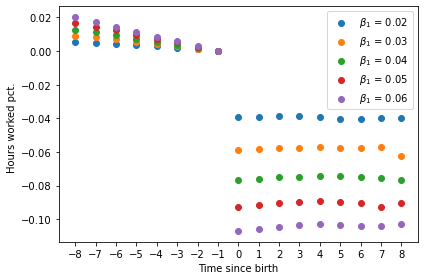

In [38]:
# b) Event study plots 
fig, ax = plt.subplots()
for beta_1 in beta_1_list:
    ax.scatter(event_grid,m_hours_b[(beta_1)],label=fr"$\beta_1$ = {beta_1}")
ax.set(xlabel='Time since birth',ylabel=f'Hours worked ',xticks=event_grid)
ax.legend();
fig.tight_layout();
fig.savefig(figpath+ r"/beta1.pdf",edgecolor='k')

fig, ax = plt.subplots()
for beta_1 in beta_1_list:
    ax.scatter(event_grid,m_hours_b[(beta_1),'rel'],label=fr"$\beta_1$ = {beta_1}")
ax.set(xlabel='Time since birth',ylabel=f'Hours worked pct.  ',xticks=event_grid)
ax.legend();
fig.tight_layout();
fig.savefig(figpath+ r"/betarel1.pdf",edgecolor='k')

In [19]:
# c) Structural estimation
def calculate_event_hours_rel_pct(beta_1):
    model.par.beta_1 = beta_1
    model.solve()
    model.simulate()

    birth = np.zeros(sim.n.shape,dtype=np.int_)
    birth[:,1:] = (sim.n[:,1:] - sim.n[:,:-1]) > 0 #G enerates an 1D-array array where 1-values indicate that a birth occurred between two periods 
    
    periods = np.tile([t for t in range(par.simT)],(par.simN,1))
    time_of_birth = np.max(periods * birth, axis=1)
    
    I = time_of_birth>0
    time_of_birth[~I] = -1000 # never has a child
    time_of_birth = np.transpose(np.tile(time_of_birth , (par.simT,1)))
    
    time_since_birth = periods - time_of_birth

    min_time = -8
    max_time = 8
    event_grid = np.arange(min_time,max_time+1)

    event_hours = np.nan + np.zeros(event_grid.size)
    for t,time in enumerate(event_grid):
        event_hours[t] = np.mean(sim.h[time_since_birth==time])

    # relative to period before birth
    event_hours_rel = event_hours - event_hours[event_grid==-1]

    event_hours_rel_pct = (event_hours - event_hours[event_grid==-1])/ event_hours[event_grid==-1] 

    event_hours_rel10_pct = event_hours_rel_pct[10] #Take out the 10th element of the array (period after birth)

    return event_hours_rel10_pct

In [35]:
target_pct_fall = -0.10

def objective(beta_1):
    event_hours_rel10_pct = calculate_event_hours_rel_pct(beta_1)
    diff = target_pct_fall - event_hours_rel10_pct
    return np.abs(diff)

# Initial guess for beta_1
initial_guess = np.array([0.057])  # Array with initial guess values
bounds = [(0.055, 0.059)]  # Array with bounds for each variable

# Run the optimization
result = optimize.minimize(objective, x0=initial_guess, method='Nelder-Mead', bounds = bounds, tol=1e-15)

# Retrieve the optimized beta_1 value
optimized_beta_1 = result.x[0]

print("Optimized beta_1 value:", optimized_beta_1)

Optimized beta_1 value: 0.056844482392072244


In [36]:
beta_1 = 0.056844482392072244
calculate_event_hours_rel_pct(beta_1)

-0.0999990658069919

# Question 2
1) In the following, I Calculate the Marshallian elasticity (ela_M). 

**Notebook**

a) First, I run a loop in which I solve the the model for tau=0.1(baseline) and tau=0.101 (new). Second, Second, I calculate average hours for individuals with and without children in each period. 
   I save average hours worked over the time period under both regimes for the average individual and conditional on children, 

b) I calculate the Marshallian elasticity by subtracting mean hours under the old regime from mean hours under new regime and dividing by hours under old regime. This provides the pct. change in average hours for each time period following a 1 pct. increase in the marginal tax. 

c) Plots 

In [ ]:
tau_list = [0.1,0.101]

In [4]:
m_hours = np.zeros((len(tau_list), par.simT))
m_cons = np.zeros((len(tau_list), par.simT))
m_assets = np.zeros((len(tau_list), par.simT))

m_hours_c0 = np.empty((len(tau_list), par.simT))
m_hours_c1 = np.empty((len(tau_list), par.simT))

m_cons_c0 = np.empty((len(tau_list), par.simT))
m_cons_c1 = np.empty((len(tau_list), par.simT))

m_assets_c0 = np.empty((len(tau_list), par.simT))
m_assets_c1 = np.empty((len(tau_list), par.simT))

In [5]:
# a) Run model for two tax regimes, conditional on having children
for i, tau in enumerate(tau_list):
    model.par.tau = tau
    model.par.phi = 0.
    model.par.theta = 0.
    model.solve()
    model.simulate()

    m_hours[i] = np.mean(getattr(sim,hours),axis=0).tolist()
    m_cons[i] = np.mean(getattr(sim,cons),axis=0).tolist()
    m_assets[i] = np.mean(getattr(sim,assets),axis=0).tolist()

    for t in range(par.simT):
        hours_c0_t = getattr(sim, hours)[getattr(sim, kids)[:, t] == 0, t]  # extract hours for c=0 for period t
        hours_c1_t = getattr(sim, hours)[getattr(sim, kids)[:, t] == 1, t]  # extract hours for c=1 for period t
        m_hours_c0[i, t] = np.mean(hours_c0_t) if hours_c0_t.size else None  # calculate mean hours for c=0 in current period t and assign to array
        m_hours_c1[i, t] = np.mean(hours_c1_t) if hours_c1_t.size else None  # calculate mean hours for c=1 in current period t and assign to array

        cons_c0_t = getattr(sim, cons)[getattr(sim, kids)[:, t] == 0, t]  
        cons_c1_t = getattr(sim, cons)[getattr(sim, kids)[:, t] == 1, t]  
        m_cons_c0[i, t] = np.mean(cons_c0_t) if cons_c0_t.size else None  
        m_cons_c1[i, t] = np.mean(cons_c1_t) if cons_c1_t.size else None  

        assets_c0_t = getattr(sim, assets)[getattr(sim, kids)[:, t] == 0, t]  
        assets_c1_t = getattr(sim, assets)[getattr(sim, kids)[:, t] == 1, t]  
        m_assets_c0[i, t] = np.mean(assets_c0_t) if assets_c0_t.size else None  
        m_assets_c1[i, t] = np.mean(assets_c1_t) if assets_c1_t.size else None 

In [6]:
# b) Take out first obs of children-arrays
m_hours_c0_n = m_hours_c0[:,1:]
m_hours_c1_n = m_hours_c1[:,1:]

m_cons_c0_n = m_cons_c0[:,1:]
m_cons_c1_n = m_cons_c1[:,1:]

m_assets_c0_n = m_assets_c0[:,1:]
m_assets_c1_n = m_assets_c1[:,1:]

In [7]:
# c) Elasticities
ela_M = ((m_hours[1]- m_hours[0])/m_hours[0])*100
ela_M_c0 = ((m_hours_c0_n[1]- m_hours_c0_n[0])/m_hours_c0_n[0])*100
ela_M_c1 = ((m_hours_c1_n[1]- m_hours_c1_n[0])/m_hours_c1_n[0])*100

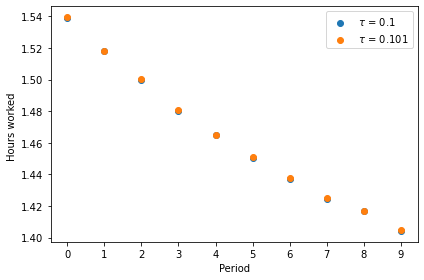

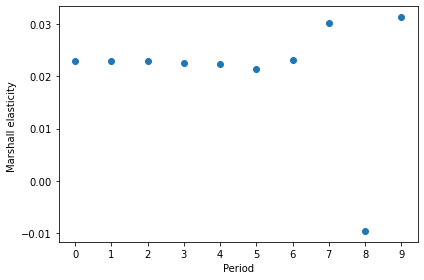

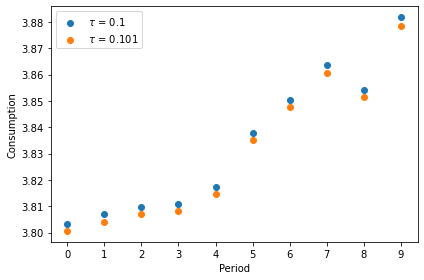

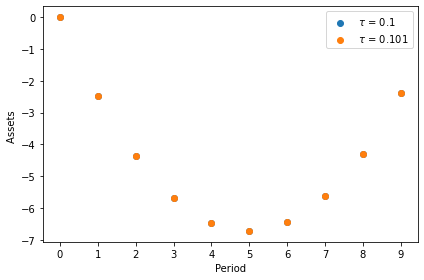

In [8]:
# d) Plots for all individuals 
periods = np.arange(0, par.T)
fig, ax = plt.subplots()
for i, tau in enumerate(tau_list):
    ax.scatter(periods,m_hours[i],label=fr"$\tau$ = {tau}")
ax.set(xlabel='Period',ylabel=f'Hours worked ',xticks=periods)
ax.legend();
fig.tight_layout();
fig.savefig(figpath+ r"/hours_2(1).pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods,ela_M)
ax.set(xlabel='Period',ylabel=f'Marshall elasticity ',xticks=periods);
fig.tight_layout();
fig.savefig(figpath+ r"/marshall_2(1).pdf",edgecolor='k')

periods = np.arange(0, par.T)
fig, ax = plt.subplots()
for i, tau in enumerate(tau_list):
    ax.scatter(periods,m_cons[i],label=fr"$\tau$ = {tau}")
ax.set(xlabel='Period',ylabel=f'Consumption',xticks=periods)
ax.legend();
fig.tight_layout();
fig.savefig(figpath+ r"/cons_2(1).pdf",edgecolor='k')

periods = np.arange(0, par.T)
fig, ax = plt.subplots()
for i, tau in enumerate(tau_list):
    ax.scatter(periods,m_assets[i],label=fr"$\tau$ = {tau}")
ax.set(xlabel='Period',ylabel=f'Assets ',xticks=periods)
ax.legend();
fig.tight_layout();
fig.savefig(figpath+ r"/assets_2(1).pdf",edgecolor='k')

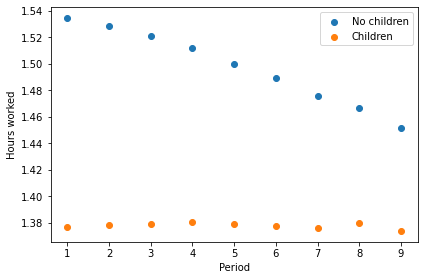

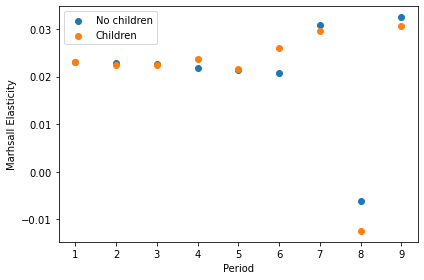

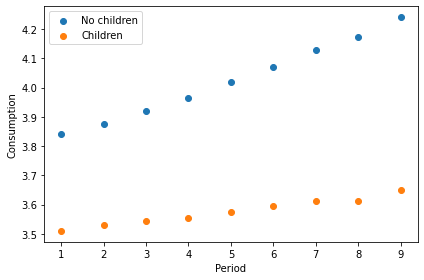

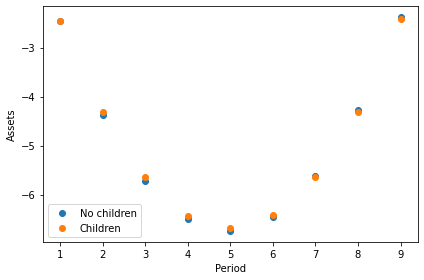

In [9]:
# d) Plots for individuals without and with children 
periods = np.arange(1, 10)

fig, ax = plt.subplots()
ax.scatter(periods, m_hours_c0_n[0], label='No children')
ax.scatter(periods, m_hours_c1_n[0], label='Children')
ax.set(xlabel='Period', ylabel='Hours worked', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/hours_2(2).pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, ela_M_c0, label='No children')
ax.scatter(periods, ela_M_c1, label='Children')
ax.set(xlabel='Period', ylabel='Marhsall Elasticity', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/marshall_2(2).pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, m_cons_c0_n[0], label='No children')
ax.scatter(periods, m_cons_c1_n[0], label='Children')
ax.set(xlabel='Period', ylabel='Consumption', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/cons_2(2).pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, m_assets_c0_n[0], label='No children')
ax.scatter(periods, m_assets_c1_n[0], label='Children')
ax.set(xlabel='Period', ylabel='Assets', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/assets_2(2).pdf",edgecolor='k')

# Question 3

**Pyfile**
- I have added parameters par.phi = 0, which I turn on when solving the model with a spouse. 
- I define an income function that includes spousal income when par.phi is turned on. 
- I call this function in both cons_last and value_of_choice. 

**Notebook**

In the run the model for values of par.\hi = [0,1] and and the two $\tau$-values to determine elasticities. 

a) I solve and simulate the model for individuals with and without spouse, under the new and old tax regime.

b) I calculate marshall elasticity for individuals without and with a spouse.

c) I plot hours worked and Marshall elasticity for individuals without and with spouse.

In [10]:
m_hours_s = np.zeros((len(tau_list), par.simT))
m_cons_s = np.zeros((len(tau_list), par.simT))
m_assets_s = np.zeros((len(tau_list), par.simT))

In [11]:
for i, tau in enumerate(tau_list):
    model.par.tau = tau
    model.par.phi = 1.
    model.par.theta = 0.
    model.solve()
    model.simulate()

    m_hours_s[i] = np.mean(getattr(sim,hours),axis=0).tolist()
    m_cons_s[i] = np.mean(getattr(sim,cons),axis=0).tolist()
    m_assets_s[i] = np.mean(getattr(sim,assets),axis=0).tolist()

In [12]:
# c) Elasticity
ela_M_s = ((m_hours_s[1]- m_hours_s[0])/m_hours_s[0])*100

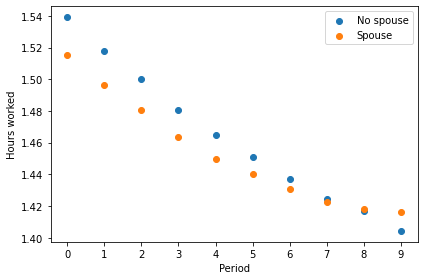

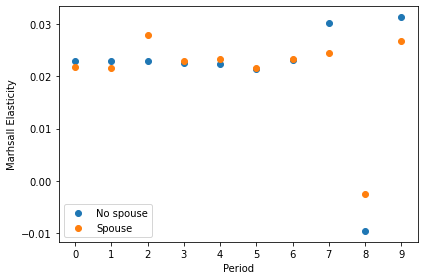

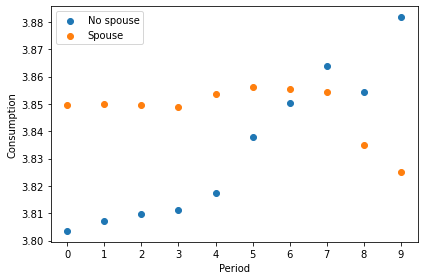

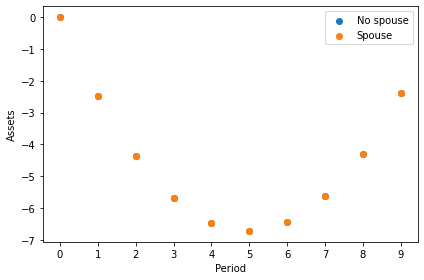

In [13]:
# c) Plots for model with and without spouse

periods = np.arange(0, 10)

fig, ax = plt.subplots()
ax.scatter(periods, m_hours[0], label='No spouse')
ax.scatter(periods, m_hours_s[0], label='Spouse')
ax.set(xlabel='Period', ylabel='Hours worked', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/hours_3.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, ela_M, label='No spouse')
ax.scatter(periods, ela_M_s, label='Spouse')
ax.set(xlabel='Period', ylabel='Marhsall Elasticity', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/marshall_3.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, m_cons[0], label='No spouse')
ax.scatter(periods, m_cons_s[0], label='Spouse')
ax.set(xlabel='Period', ylabel='Consumption', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/cons_3.pdf",edgecolor='k')


fig, ax = plt.subplots()
ax.scatter(periods, m_assets[0], label='No spouse')
ax.scatter(periods, m_assets[0], label='Spouse')
ax.set(xlabel='Period', ylabel='Assets', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/assets_3.pdf",edgecolor='k')

# Question 4

**Pyfile**
- I have added parameter par.theta = 0.
- I turn this parameter on when I want to solve the model with a child costs.
- Child costs are included in the income function when children are present. 
- I call this function in both cons_last and value_of_choice. 
- I also add par.theta*kids to hours_min as child costs are now part of the lower bound for how many hours needs to be worked.

**Notebook**

In the run the model for values of par.theta = [0,0.05] and the two $\tau$-values to determine elasticities. 

a) Solve and simulate model for individuals with and without child costs, under the new and old tax regime

b) Calculate marshall elasticity for individuals facing and not facing child costs 

c) Plot hours worked and Marshall elasticity for individuals facing child costs

In [14]:
m_hours_cc = np.empty((len(tau_list), par.simT))
m_cons_cc = np.empty((len(tau_list), par.simT))
m_assets_cc = np.empty((len(tau_list), par.simT))

In [15]:
# a) Run model with child care costs for two tax regimes and for individuals with and without kids
for i, tau in enumerate(tau_list):
    model.par.tau = tau
    model.par.phi = 0.
    model.par.theta = 0.05
    model.solve()
    model.simulate()

    for t in range(par.simT):
        hours_cc_t = getattr(sim, hours)[getattr(sim, kids)[:, t] == 1, t]  # extract hours for c=1 for period t
        m_hours_cc[i, t] = np.mean(hours_cc_t) if hours_cc_t.size else None  # calculate mean hours for c=1 in current period t and assign to array
 
        cons_cc_t = getattr(sim, cons)[getattr(sim, kids)[:, t] == 1, t]  
        m_cons_cc[i, t] = np.mean(cons_cc_t) if cons_cc_t.size else None 

        assets_cc_t = getattr(sim, assets)[getattr(sim, kids)[:, t] == 1, t]  
        m_assets_cc[i, t] = np.mean(assets_cc_t) if assets_cc_t.size else None 

In [19]:
# b) take out first obs
m_hours_cc_n = m_hours_cc[:,1:]
m_cons_cc_n = m_cons_cc[:,1:]
m_assets_cc_n = m_assets_cc[:,1:]

In [20]:
# c) elasticities
ela_M_cc = ((m_hours_cc_n[1]- m_hours_cc_n[0])/m_hours_cc_n[0])*100

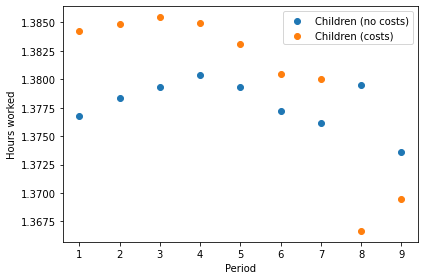

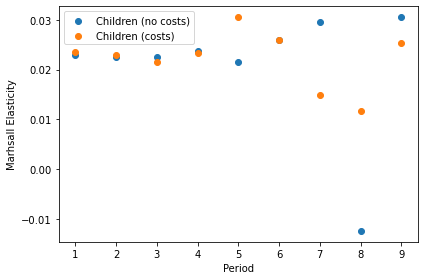

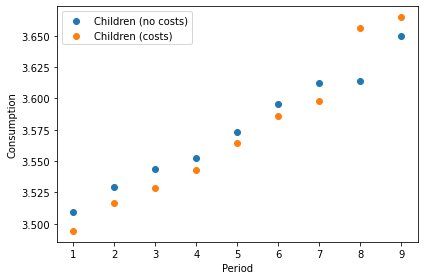

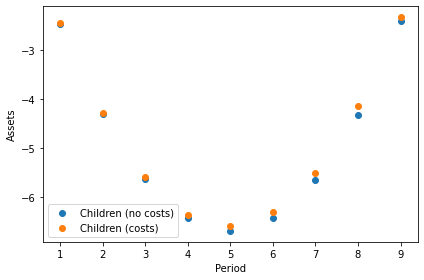

In [21]:
# d) Plot hours worked and Marshall elasticity in model with and without child costs 
periods = np.arange(1, 10)

fig, ax = plt.subplots()
ax.scatter(periods, m_hours_c1_n[0], label='Children (no costs)')
ax.scatter(periods, m_hours_cc_n[0], label='Children (costs)')
ax.set(xlabel='Period', ylabel='Hours worked', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/hours_4.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, ela_M_c1, label='Children (no costs)')
ax.scatter(periods, ela_M_cc, label='Children (costs)')
ax.set(xlabel='Period', ylabel='Marhsall Elasticity', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/marshall_4.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, m_cons_c1_n[0], label='Children (no costs)')
ax.scatter(periods, m_cons_cc_n[0], label='Children (costs)')
ax.set(xlabel='Period', ylabel='Consumption', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/cons_4.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, m_assets_c1_n[0], label='Children (no costs)')
ax.scatter(periods, m_assets_cc_n[0], label='Children (costs)')
ax.set(xlabel='Period', ylabel='Assets', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/assets_4.pdf",edgecolor='k')

# Question 6

**Pyfile**

- I have added a state variable i_s. 
- I initiate with this with two elements when I want to solve the model with a stochastic spouse. In the baseline model, there is only one element such that a spouse is always present, but par.phi = 0 so that spouse contributes with zero income. 
- When solving the model with a stochastic spouse, I write up the conditional probabilities of having a child in the next period and having a spouse. Te expected value function of later periods depend on these probabilities. See math in pdf-file. 

I also add par.phi $\cdot$ spouse $\cdot$ (0.1+0.01) to hours_min as spousal income now lowers the lower bound for how many hours needs to be worked in order to satisfy minimum consumption. 

**Notebook**

a) I solve and simulate the baseline model where par.stoch_s = 0, par.phi = 0 and par.theta = 0.

b) I save mean hours worked, consumption, assets and kids 

c) I solve and simulate the new model where par.stoch_s = 1, par.phi = 1 and par.theta = 0.05.

d) I save mean hours worked, consumption, assets and kids 

e) Solve stochastic spouse model under new and old tax regime

f) Calculate Marshallian elasticity in new model

g) Plot all four variables for the two models


In [39]:
# load local model file and initialize model class
from Pyfile import DynLaborFertModelClass
model1 = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3,'stoch_s':0}) # set a few number of periods.

par = model1.par
sol = model1.sol
sim = model1.sim

In [40]:
# a) Solve and simulate baseline model 
model1.solve()
model1.simulate()

In [41]:
# b) Save variables
model1_hours = np.mean(getattr(sim, hours), axis=0).tolist()
model1_cons = np.mean(getattr(sim, cons), axis=0).tolist()
model1_assets = np.mean(getattr(sim, assets), axis=0).tolist()
model1_kids  = np.mean(getattr(sim, kids), axis=0).tolist()
model1_spouse  = np.mean(getattr(sim, spouse), axis=0).tolist()

In [42]:
# load local model file and initialize model class
from Pyfile import DynLaborFertModelClass
model2 = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3,'stoch_s':1}) # set a few number of periods.

par = model2.par
sol = model2.sol
sim = model2.sim

In [43]:
# c) Solve and simulate new model
model2.solve()
model2.simulate()

In [44]:
# d) Save variables
model2_hours = np.mean(getattr(sim, hours), axis=0).tolist()
model2_cons = np.mean(getattr(sim, cons), axis=0).tolist()
model2_assets = np.mean(getattr(sim, assets), axis=0).tolist()
model2_kids  = np.mean(getattr(sim, kids), axis=0).tolist()
model2_spouse  = np.mean(getattr(sim, spouse), axis=0).tolist()

In [45]:
# e) Solve stochastic spouse model for tau = 0.1 (baseline) and tau=0.101
tau_list = [0.1,0.101]
m_hours_ss = np.zeros((len(tau_list), par.simT))

for i, tau in enumerate(tau_list):
    model2.par.tau = tau
    model2.par.phi = 1. # spouse income
    model2.par.theta = 0.05 #child cost 
    model2.solve()
    model2.simulate()
    m_hours_ss[i] = np.mean(getattr(sim,hours),axis=0).tolist()

In [46]:
# f) Calculate Marshallian elasticity
ela_M_ss = ((m_hours_ss[1]- m_hours_ss[0])/m_hours_ss[0])*100

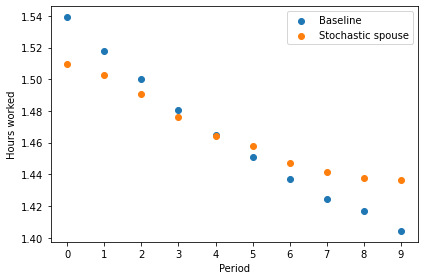

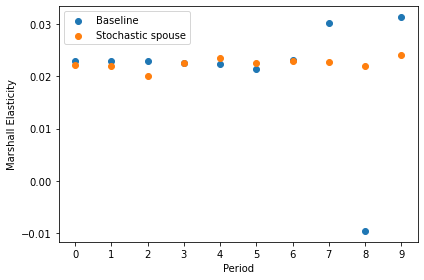

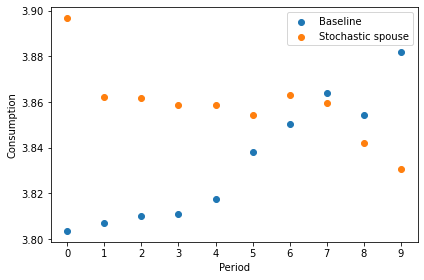

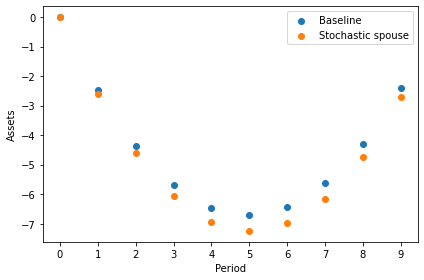

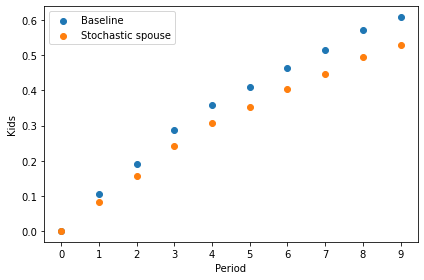

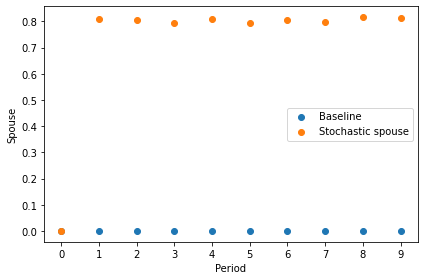

In [47]:
# 6.7) Plot variables
periods = np.arange(0, 10)

fig, ax = plt.subplots()
ax.scatter(periods, model1_hours, label='Baseline')
ax.scatter(periods, model2_hours, label='Stochastic spouse')
ax.set(xlabel='Period', ylabel='Hours worked', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/hours_6.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, ela_M, label='Baseline')
ax.scatter(periods, ela_M_ss, label='Stochastic spouse')
ax.set(xlabel='Period', ylabel='Marshall Elasticity', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/marshall_6.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, model1_cons, label='Baseline')
ax.scatter(periods, model2_cons, label='Stochastic spouse')
ax.set(xlabel='Period', ylabel='Consumption', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/cons_6.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, model1_assets, label='Baseline')
ax.scatter(periods, model2_assets, label='Stochastic spouse')
ax.set(xlabel='Period', ylabel='Assets', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/assets_6.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, model1_kids, label='Baseline')
ax.scatter(periods, model2_kids, label='Stochastic spouse')
ax.set(xlabel='Period', ylabel='Kids', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/kids_6.pdf",edgecolor='k')

fig, ax = plt.subplots()
ax.scatter(periods, model1_spouse, label='Baseline')
ax.scatter(periods, model2_spouse, label='Stochastic spouse')
ax.set(xlabel='Period', ylabel='Spouse', xticks=periods)
ax.legend()
fig.tight_layout();
fig.savefig(figpath+ r"/spouse_6.pdf",edgecolor='k')